In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import os, sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import skimage.io
from skimage.transform import resize
from imgaug import augmenters as iaa
from tqdm import tqdm
import PIL
from PIL import Image
import cv2
from sklearn.utils import class_weight, shuffle
from scipy.misc import imread
import seaborn as sns

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

import os
print(os.listdir("../input"))

# Any results you write to the current directory are saved as output.

modelFile = '../working/ConvPool_A.h5'
submitFile = '../working/ConvPool_A.csv'
loss_function = 'binary_crossentropy'
#loss_function = focal_loss
epochs = 10
lr = 1e-03 
threshold = 0.35 # due to different cost of True Positive vs False Positive, this is the probability threshold to predict the class as 'yes'


['train.zip', 'train.csv', 'test.zip', 'test', 'train', 'sample_submission.csv', '.ipynb_checkpoints']


In [2]:
import tensorflow as tf; 
print(tf.__version__)
import keras; 
from keras import backend as K
print(keras.__version__)

1.11.0
2.2.4


Using TensorFlow backend.


In [3]:
import warnings
warnings.filterwarnings("ignore")

In [63]:
#SIZE = 299   #Inception
SIZE = 224   #ResNet50
BATCH_SIZE = 64
SEED = 777

SHAPE = (224, 224, 4)
CUST_SHAPE = (128,128,4)
#SHAPE = (229, 229, 3)
VAL_RATIO = 0.2 # 20 % as validation

DIR = '../input'
gamma = 2.0
import keras
epsilon = K.epsilon()

In [5]:
import time
print("DateTime " + time.strftime("%c"))
start = time.time()

DateTime Mon Nov 26 20:26:06 2018


In [6]:
label_names = {
    0:  "Nucleoplasm",  
    1:  "Nuclear membrane",   
    2:  "Nucleoli",   
    3:  "Nucleoli fibrillar center",   
    4:  "Nuclear speckles",
    5:  "Nuclear bodies",   
    6:  "Endoplasmic reticulum",   
    7:  "Golgi apparatus",   
    8:  "Peroxisomes",   
    9:  "Endosomes",   
    10:  "Lysosomes",   
    11:  "Intermediate filaments",   
    12:  "Actin filaments",   
    13:  "Focal adhesion sites",   
    14:  "Microtubules",   
    15:  "Microtubule ends",   
    16:  "Cytokinetic bridge",   
    17:  "Mitotic spindle",   
    18:  "Microtubule organizing center",   
    19:  "Centrosome",   
    20:  "Lipid droplets",   
    21:  "Plasma membrane",   
    22:  "Cell junctions",   
    23:  "Mitochondria",   
    24:  "Aggresome",   
    25:  "Cytosol",   
    26:  "Cytoplasmic bodies",   
    27:  "Rods & rings"
}

reverse_train_labels = dict((v,k) for k,v in label_names.items())

def getTargetNames(row):
    row.Target = np.array(row.Target.split(" ")).astype(np.int)
    names = []
    for num in row.Target:
        name = label_names[int(num)]
        names.append(name)
    return row

def fill_targets(row):
    row.Target = np.array(row.Target.split(" ")).astype(np.int)
    for num in row.Target:
        name = label_names[int(num)]
        row.loc[name] = 1
    return row

In [7]:
def getTrainDataset():
    
    path_to_train = DIR + '/train/'
    data = pd.read_csv(DIR + '/train.csv')

    paths = []
    labels = []
    
    for name, lbl in zip(data['Id'], data['Target'].str.split(' ')):
        y = np.zeros(28)
        for key in lbl:
            y[int(key)] = 1
        paths.append(os.path.join(path_to_train, name))
        labels.append(y)

    return np.array(paths), np.array(labels)

def getTestDataset():
    
    path_to_test = DIR + '/test/'
    data = pd.read_csv(DIR + '/sample_submission.csv')

    paths = []
    labels = []
    
    for name in data['Id']:
        y = np.ones(28)
        paths.append(os.path.join(path_to_test, name))
        labels.append(y)

    return np.array(paths), np.array(labels)


In [8]:

class ProteinDataGenerator(keras.utils.Sequence):
            
    def __init__(self, paths, labels, batch_size, shape, shuffle = False, use_cache = False, augment = False,channels=3):
        self.paths, self.labels = paths, labels
        self.batch_size = batch_size
        self.shape = shape
        self.shuffle = shuffle
        self.use_cache = use_cache
        self.augment = augment
        self.channels = channels
        if use_cache == True:
            self.cache = np.zeros((paths.shape[0], shape[0], shape[1], shape[2]), dtype=np.float16)
            self.is_cached = np.zeros((paths.shape[0]))
        self.on_epoch_end()
    
    def __len__(self):
        return int(np.ceil(len(self.paths) / float(self.batch_size)))
    
    def __getitem__(self, idx):
        indexes = self.indexes[idx * self.batch_size : (idx+1) * self.batch_size]
        paths = np.array([self.paths[k] for k in indexes])
        X = np.zeros((paths.shape[0], self.shape[0], self.shape[1], self.shape[2]))
        # Generate data
        if self.use_cache == True:
            X = self.cache[indexes]
            for i, path in enumerate(paths[np.where(self.is_cached[indexes] == 0)]):
                image = self.load_image(path)
                self.is_cached[indexes[i]] = 1
                self.cache[indexes[i]] = image
                X[i] = image
        else:
            for i, path in enumerate(paths):
                X[i] = self.load_image(path)

        y = np.array([self.labels[k] for k in indexes])
#        y = self.labels[indexes]
                
        if self.augment == True:
            seq = iaa.Sequential([
                iaa.OneOf([
                    iaa.Fliplr(0.5), # horizontal flips
                    iaa.Flipud(0.5),  #vertical flips
                    iaa.Crop(percent=(0, 0.1)), # random crops
                    # Small gaussian blur with random sigma between 0 and 0.5.
                    # But we only blur about 50% of all images.  **** Not clear that this is doing anything ****
                    iaa.Sometimes(0.5,
                        iaa.GaussianBlur(sigma=(0, 0.5))
                    ),
                    # Strengthen or weaken the contrast in each image.
#                    iaa.ContrastNormalization((0.75, 1.5)),
                    # Strengthen Contrast !
                    iaa.ContrastNormalization((0.1, 0.25)),
                    # Add gaussian noise.
                    # For 50% of all images, we sample the noise once per pixel.
                    # For the other 50% of all images, we sample the noise per pixel AND
                    # channel. This can change the color (not only brightness) of the
                    # pixels.
 #                   iaa.AdditiveGaussianNoise(loc=0, scale=(0.0, 0.05*255), per_channel=0.5),
                    # Make some images brighter and some darker.
                    # In 20% of all cases, we sample the multiplier once per channel,
                    # which can end up changing the color of the images.
                    iaa.Multiply((0.8, 1.2), per_channel=0.2),
                    # Apply affine transformations to each image.
                    # Scale/zoom them, translate/move them, rotate them and shear them.
                    iaa.Affine(rotate=90),
                    iaa.Affine(rotate=180),
                    iaa.Affine(rotate=270),
                    iaa.Affine(
                        scale={"x": (0.8, 1.2), "y": (0.8, 1.2)},
                        translate_percent={"x": (-0.2, 0.2), "y": (-0.2, 0.2)},
                        rotate=(-180, 180),
                        shear=(-8, 8)
                    )
                ])], random_order=True)

            X = seq.augment_images(X)
#        if self.augment == True:
#            seq = iaa.Sequential([
#                iaa.OneOf([
#                    iaa.Fliplr(0.5), # horizontal flips
#                    iaa.Crop(percent=(0, 0.1)), # random crops
#                    # Small gaussian blur with random sigma between 0 and 0.5.
#                    # But we only blur about 50% of all images.
#                    iaa.Sometimes(0.5,
#                        iaa.GaussianBlur(sigma=(0, 0.5))
#                    ),
#                    # Strengthen or weaken the contrast in each image.
#                    iaa.ContrastNormalization((0.75, 1.5)),
#                    # Add gaussian noise.
#                    # For 50% of all images, we sample the noise once per pixel.
#                    # For the other 50% of all images, we sample the noise per pixel AND
#                    # channel. This can change the color (not only brightness) of the
#                    # pixels.
#                   iaa.AdditiveGaussianNoise(loc=0, scale=(0.0, 0.05*255), per_channel=0.5),
#                    # Make some images brighter and some darker.
#                    # In 20% of all cases, we sample the multiplier once per channel,
#                    # which can end up changing the color of the images.
#                    iaa.Multiply((0.8, 1.2), per_channel=0.2),
#                    # Apply affine transformations to each image.
#                    # Scale/zoom them, translate/move them, rotate them and shear them.
#                    iaa.Affine(
#                        scale={"x": (0.8, 1.2), "y": (0.8, 1.2)},
#                        translate_percent={"x": (-0.2, 0.2), "y": (-0.2, 0.2)},
#                        rotate=(-180, 180),
#                        shear=(-8, 8)
#                    )
#                ])], random_order=True)
#
#            X = np.concatenate((X, seq.augment_images(X), seq.augment_images(X), seq.augment_images(X)), 0)
#            y = np.concatenate((y, y, y, y), 0)
        
        return X, y
    
    def on_epoch_end(self):
        
        # Updates indexes after each epoch
        self.indexes = np.arange(len(self.paths))
        if self.shuffle == True:
            np.random.shuffle(self.indexes)

    def __iter__(self):
        """Create a generator that iterate over the Sequence."""
        for item in (self[i] for i in range(len(self))):
            yield item
    
    def load4Channel(self, path):
        image_red_ch = Image.open(path+'_red.png')
        image_yellow_ch = Image.open(path+'_yellow.png')
        image_green_ch = Image.open(path+'_green.png')
        image_blue_ch = Image.open(path+'_blue.png')
        image = np.stack((
        np.array(image_red_ch), 
        np.array(image_yellow_ch),     
        np.array(image_green_ch), 
        np.array(image_blue_ch)), -1)
        image = cv2.resize(image, (self.shape[0], self.shape[1]))
        im = np.divide(image, 255) 
        return im

    def load3Channel(self, path):
        image_red_ch = Image.open(path+'_red.png')
        image_yellow_ch = Image.open(path+'_yellow.png')
        image_green_ch = Image.open(path+'_green.png')
        image_blue_ch = Image.open(path+'_blue.png')
        image = np.stack((
        np.array(image_red_ch), 
        np.array(image_green_ch), 
        np.array(image_blue_ch)), -1)
        image = cv2.resize(image, (self.shape[0], self.shape[1]))
        im = np.divide(image, 255)
        return im

    def load_image(self, path):
        if self.channels == 3:
            return self.load3Channel(path)
        else:
            return self.load4Channel(path)

In [9]:
import keras
from keras.models import Sequential, Model, load_model
from keras.layers.merge import concatenate
from keras.layers import Activation, Dense, Dropout, Multiply, Input, GlobalAveragePooling2D, Flatten, Conv2D, Concatenate, ReLU, LeakyReLU, BatchNormalization, MaxPooling2D, Lambda
from keras.callbacks import ModelCheckpoint, EarlyStopping, LearningRateScheduler
from keras import metrics
from keras.optimizers import Adam  
from keras import backend as K


def conv_pool_cnn(model_input, n_out):
    x = Conv2D(96, kernel_size=(3, 3), activation='relu', padding = 'same')(model_input)
    x = Conv2D(96, (3, 3), activation='relu', padding = 'same')(x)
    x = Conv2D(96, (3, 3), activation='relu', padding = 'same')(x)
    x = MaxPooling2D(pool_size=(3, 3), strides = 2)(x)
    x = Conv2D(192, (3, 3), activation='relu', padding = 'same')(x)
    x = Conv2D(192, (3, 3), activation='relu', padding = 'same')(x)
    x = Conv2D(192, (3, 3), activation='relu', padding = 'same')(x)
    x = MaxPooling2D(pool_size=(3, 3), strides = 2)(x)
    x = Conv2D(192, (3, 3), activation='relu', padding = 'same')(x)
    x = Conv2D(192, (1, 1), activation='relu')(x)
    x = Conv2D(28, (1, 1))(x)
    x = GlobalAveragePooling2D()(x)
    x = Activation(activation='sigmoid')(x)
    
    model = Model(model_input, x, name='conv_pool_cnn')
    
    return model

In [10]:
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, EarlyStopping, ReduceLROnPlateau
checkpoint = ModelCheckpoint(modelFile, monitor='val_loss', verbose=1, 
                             save_best_only=True, mode='min', save_weights_only = False)
#checkpoint = ModelCheckpoint('../working/ResNet50A.h5', monitor='val_loss', verbose=1, 
#                             save_best_only=True, mode='min', save_weights_only = False)
reduceLROnPlat = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=3, 
                                   verbose=1, mode='auto', epsilon=0.0001)
early = EarlyStopping(monitor="val_loss", 
                      mode="min", 
                      patience=6)
callbacks_list = [checkpoint, early, reduceLROnPlat]

In [11]:
# split data into train, valid
paths, labels = getTrainDataset()

# divide to 
keys = np.arange(paths.shape[0], dtype=np.int)  
np.random.seed(SEED)
np.random.shuffle(keys)
lastTrainIndex = int((1-VAL_RATIO) * paths.shape[0])

#print(lastIndex, lastTrainIndex, int(lastTrainIndex * 0.8))
pathsTrain = paths[0:lastTrainIndex]
labelsTrain = labels[0:lastTrainIndex]
pathsVal = paths[lastTrainIndex:]
labelsVal = labels[lastTrainIndex:]

print(paths.shape, labels.shape)
print(pathsTrain.shape, labelsTrain.shape, pathsVal.shape, labelsVal.shape)

train_generator = ProteinDataGenerator(pathsTrain, labelsTrain, BATCH_SIZE, CUST_SHAPE, use_cache=False, channels=4, augment = True, shuffle = False)
validation_generator = ProteinDataGenerator(pathsVal, labelsVal, BATCH_SIZE, CUST_SHAPE, use_cache=False, channels=4, augment=True, shuffle = False)

(31072,) (31072, 28)
(24857,) (24857, 28) (6215,) (6215, 28)


In [60]:
tf.reset_default_graph()
K.clear_session()
protein_model_input = Input(CUST_SHAPE)
protein_classes = len(label_names)

model = conv_pool_cnn(protein_model_input, protein_classes)


In [13]:
def focal_loss(y_true, y_pred):
    pt = y_pred * y_true + (1-y_pred) * (1-y_true)
    pt = K.clip(pt, epsilon, 1-epsilon)
    CE = -K.log(pt)
    FL = K.pow(1-pt, gamma) * CE
    loss = K.sum(FL, axis=1)
    return loss


def f1(y_true, y_pred):
    y_pred = K.round(y_pred)
    tp = K.sum(K.cast(y_true*y_pred, 'float'), axis=0)
    tn = K.sum(K.cast((1-y_true)*(1-y_pred), 'float'), axis=0)
    fp = K.sum(K.cast((1-y_true)*y_pred, 'float'), axis=0)
    fn = K.sum(K.cast(y_true*(1-y_pred), 'float'), axis=0)

    p = tp / (tp + fp + K.epsilon())
    r = tp / (tp + fn + K.epsilon())

    f1 = 2*p*r / (p+r+K.epsilon())
    f1 = tf.where(tf.is_nan(f1), tf.zeros_like(f1), f1)
    return K.mean(f1)

def f1PR(y_true, y_pred):
    y_pred = K.round(y_pred)
    tp = K.sum(K.cast(y_true*y_pred, 'float'), axis=0)
    tn = K.sum(K.cast((1-y_true)*(1-y_pred), 'float'), axis=0)
    fp = K.sum(K.cast((1-y_true)*y_pred, 'float'), axis=0)
    fn = K.sum(K.cast(y_true*(1-y_pred), 'float'), axis=0)

    p = tp / (tp + fp + K.epsilon())
    r = tp / (tp + fn + K.epsilon())

    f1 = 2*p*r / (p+r+K.epsilon())
    f1 = tf.where(tf.is_nan(f1), tf.zeros_like(f1), f1)
    return K.mean(f1), K.mean(p), K.mean(r)

def f1_loss(y_true, y_pred):
    
    tp = K.sum(K.cast(y_true*y_pred, 'float'), axis=0)
    tn = K.sum(K.cast((1-y_true)*(1-y_pred), 'float'), axis=0)
    fp = K.sum(K.cast((1-y_true)*y_pred, 'float'), axis=0)
    fn = K.sum(K.cast(y_true*(1-y_pred), 'float'), axis=0)

    p = tp / (tp + fp + K.epsilon())
    r = tp / (tp + fn + K.epsilon())

    f1 = 2*p*r / (p+r+K.epsilon())
    f1 = tf.where(tf.is_nan(f1), tf.zeros_like(f1), f1)
    return 1 - K.mean(f1)

def fbeta(y_true, y_pred, threshold_shift=0):
    beta = 2

    # just in case of hipster activation at the final layer
    y_pred = K.clip(y_pred, 0, 1)

    # shifting the prediction threshold from .5 if needed
    y_pred_bin = K.round(y_pred + threshold_shift)

    tp = K.sum(K.round(y_true * y_pred_bin)) + K.epsilon()
    fp = K.sum(K.round(K.clip(y_pred_bin - y_true, 0, 1)))
    fn = K.sum(K.round(K.clip(y_true - y_pred, 0, 1)))

    precision = tp / (tp + fp)
    recall = tp / (tp + fn)

    beta_squared = beta ** 2
    return (beta_squared + 1) * (precision * recall) / (beta_squared * precision + recall + K.epsilon())

In [88]:
model.compile(
    loss=loss_function,
    optimizer=Adam(lr),    
    metrics=['acc', f1])
model.summary()
model.load_weights("../working/ResNet50BXF.h5")

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 128, 128, 4)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 128, 128, 96)      3552      
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 128, 128, 96)      83040     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 128, 128, 96)      83040     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 63, 63, 96)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 63, 63, 192)       166080    
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 63, 63, 192)       331968    
__________

In [15]:
hist = model.fit_generator(
    train_generator,
    steps_per_epoch=len(train_generator),
    validation_data=validation_generator,
    validation_steps=8,
    epochs=epochs, 
    verbose=1,
    callbacks=callbacks_list)

Epoch 1/10
389/389 [==============================] - 273s 702ms/step - loss: 0.1877 - acc: 0.9391 - f1: 0.0023 - val_loss: 0.1825 - val_acc: 0.9346 - val_f1: 0.0209

Epoch 00001: val_loss improved from inf to 0.18248, saving model to ../working/ResNet50BXF.h5
Epoch 2/10
389/389 [==============================] - 271s 697ms/step - loss: 0.1752 - acc: 0.9416 - f1: 2.3922e-04 - val_loss: 0.1747 - val_acc: 0.9431 - val_f1: 0.0000e+00

Epoch 00002: val_loss improved from 0.18248 to 0.17469, saving model to ../working/ResNet50BXF.h5
Epoch 3/10
389/389 [==============================] - 271s 696ms/step - loss: 0.1719 - acc: 0.9414 - f1: 0.0084 - val_loss: 0.1686 - val_acc: 0.9428 - val_f1: 0.0130

Epoch 00003: val_loss improved from 0.17469 to 0.16862, saving model to ../working/ResNet50BXF.h5
Epoch 4/10
389/389 [==============================] - 271s 698ms/step - loss: 0.1634 - acc: 0.9463 - f1: 0.0334 - val_loss: 0.1592 - val_acc: 0.9478 - val_f1: 0.0319

Epoch 00004: val_loss improved fro

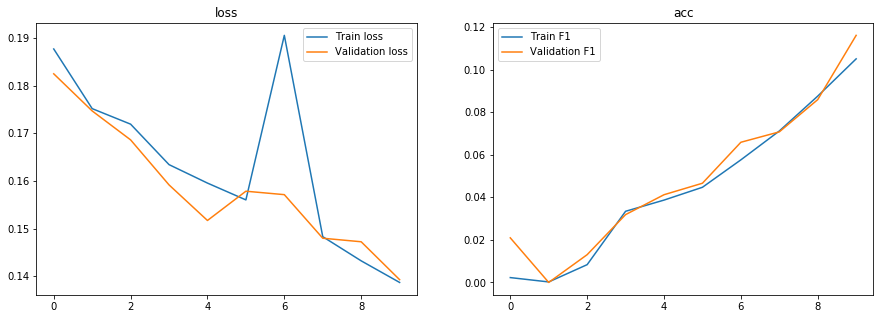

In [16]:
fig, ax = plt.subplots(1, 2, figsize=(15,5))
ax[0].set_title('loss')
ax[0].plot(hist.epoch, hist.history["loss"], label="Train loss")
ax[0].plot(hist.epoch, hist.history["val_loss"], label="Validation loss")
ax[1].set_title('acc')
ax[1].plot(hist.epoch, hist.history["f1"], label="Train F1")
ax[1].plot(hist.epoch, hist.history["val_f1"], label="Validation F1")
ax[0].legend()
ax[1].legend()

In [89]:
# Fine Tune Model with Bigger Image
train_generator = ProteinDataGenerator(pathsTrain, labelsTrain, BATCH_SIZE, SHAPE, use_cache=False, channels=4, augment = True, shuffle = False)
validation_generator = ProteinDataGenerator(pathsVal, labelsVal, BATCH_SIZE, SHAPE, use_cache=False, channels=4, augment=True, shuffle = False)

# Build new model for larger image, transfer prev model weights over and continue training
model2 = conv_pool_cnn(Input(SHAPE), protein_classes)
model2.set_weights(model.get_weights())
model2.compile(
    loss=loss_function,
    optimizer=Adam(lr),    
    metrics=['acc', f1])
model2.summary()

hist2 = model2.fit_generator(
    train_generator,
    steps_per_epoch=len(train_generator),
    validation_data=validation_generator,
    validation_steps=8,
    epochs=epochs, 
    verbose=1,
    callbacks=callbacks_list)


(?, 128, 128, 4)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         (None, 224, 224, 4)       0         
_________________________________________________________________
conv2d_38 (Conv2D)           (None, 224, 224, 96)      3552      
_________________________________________________________________
conv2d_39 (Conv2D)           (None, 224, 224, 96)      83040     
_________________________________________________________________
conv2d_40 (Conv2D)           (None, 224, 224, 96)      83040     
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 111, 111, 96)      0         
_________________________________________________________________
conv2d_41 (Conv2D)           (None, 111, 111, 192)     166080    
_________________________________________________________________
conv2d_42 (Conv2D)           (None, 111, 111, 192)     3319

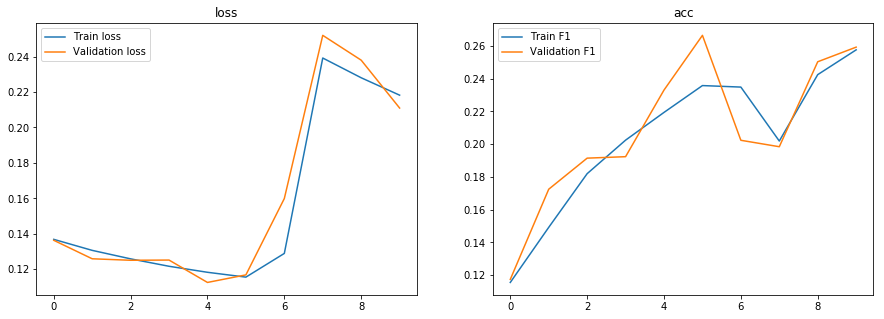

In [90]:
fig, ax = plt.subplots(1, 2, figsize=(15,5))
ax[0].set_title('loss')
ax[0].plot(hist2.epoch, hist2.history["loss"], label="Train loss")
ax[0].plot(hist2.epoch, hist2.history["val_loss"], label="Validation loss")
ax[1].set_title('acc')
ax[1].plot(hist2.epoch, hist2.history["f1"], label="Train F1")
ax[1].plot(hist2.epoch, hist2.history["val_f1"], label="Validation F1")
ax[0].legend()
ax[1].legend()

In [105]:
# Fine Tune Model with Bigger Image
# train_generator = ProteinDataGenerator(pathsTrain, labelsTrain, BATCH_SIZE, (512, 512, 4), use_cache=False, channels=4, augment = True, shuffle = False)
# validation_generator = ProteinDataGenerator(pathsVal, labelsVal, BATCH_SIZE, (512, 512, 4) use_cache=False, channels=4, augment=True, shuffle = False)

# Build new model for larger image, transfer prev model weights over and continue training
# Ran out of memory for 3rd stage of training

# model3 = conv_pool_cnn(Input((300, 300, 4)), protein_classes)
# model3.set_weights(model2.get_weights())
# model3.compile(
#     loss=loss_function,
#     optimizer=Adam(lr),    
#     metrics=['acc', f1])
# model3.summary()

# hist3 = model3.fit_generator(
#     train_generator,
#     steps_per_epoch=len(train_generator),
#     validation_data=validation_generator,
#     validation_steps=8,
#     epochs=epochs, 
#     verbose=1,
#     callbacks=callbacks_list)

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(15,5))
ax[0].set_title('loss')
ax[0].plot(hist3.epoch, hist3.history["loss"], label="Train loss")
ax[0].plot(hist3.epoch, hist3.history["val_loss"], label="Validation loss")
ax[1].set_title('acc')
ax[1].plot(hist3.epoch, hist3.history["f1"], label="Train F1")
ax[1].plot(hist3.epoch, hist3.history["val_f1"], label="Validation F1")
ax[0].legend()
ax[1].legend()

In [98]:
valGen = ProteinDataGenerator(pathsVal,labelsVal, BATCH_SIZE, SHAPE, channels=4)
#customObjects = {}        #Needed for loading models with saved loss functions ... have not tested for no custom objects
#customObjects={'f1': f1, 'focal_loss': focal_loss}
#customObjects={'f1': f1}
#model = load_model(modelFile,custom_objects=customObjects)

In [99]:
from sklearn.metrics import f1_score as off1

def getOptimalT(mdl, valGen):
    
    valPred = np.empty((0, 28))
    valLabels = np.empty((0, 28))
    for i in tqdm(range(len(valGen))): 
        im, lbl = valGen[i]
        scores = mdl.predict(im)
        valPred = np.append(valPred, scores, axis=0)
        valLabels = np.append(valLabels, lbl, axis=0)
    print(valPred.shape, valLabels.shape)
    
    rng = np.arange(0, 1, 0.001)
    f1s = np.zeros((rng.shape[0], 28))
    for j,t in enumerate(tqdm(rng)):
        for i in range(28):
            p = np.array(valPred[:,i]>t, dtype=np.int8)
            #scoref1 = K.eval(f1(valLabels[:,i], p))
            scoref1 = off1(valLabels[:,i], p, average='binary')
            f1s[j,i] = scoref1
            
    print(np.max(f1s, axis=0))
    print(np.mean(np.max(f1s, axis=0)))
    
    plt.plot(rng, f1s)
    T = np.empty(28)
    for i in range(28):
        T[i] = rng[np.where(f1s[:,i] == np.max(f1s[:,i]))[0][0]]
    print('Choosing threshold: ', T)
#    print('Validation F1-score: ', max(f1s))
#    print(T)
    
    return T, np.mean(np.max(f1s, axis=0))

  0%|          | 0/98 [00:00<?, ?it/s]

Last model after fine-tuning


  0%|          | 3/1000 [00:00<00:39, 25.49it/s]

(6215, 28) (6215, 28)


100%|██████████| 1000/1000 [00:35<00:00, 28.30it/s]


[8.18540064e-01 8.07453416e-01 7.17655468e-01 5.96252129e-01
 7.38903394e-01 5.89870904e-01 4.93150685e-01 6.54268808e-01
 3.07692308e-01 8.69565217e-02 9.09090909e-02 4.83516484e-01
 3.60000000e-01 5.02512563e-01 8.35322196e-01 3.00300300e-03
 1.54285714e-01 2.68656716e-01 3.64016736e-01 4.70254958e-01
 2.09523810e-01 5.86618877e-01 3.49295775e-01 7.14529915e-01
 6.36363636e-01 6.63569281e-01 2.83464567e-01 3.21750322e-04]
0.4566753131808385
Choosing threshold:  [0.418 0.132 0.192 0.216 0.255 0.228 0.348 0.204 0.036 0.03  0.066 0.18
 0.257 0.215 0.419 0.002 0.047 0.095 0.086 0.117 0.067 0.258 0.143 0.212
 0.275 0.339 0.092 0.   ]


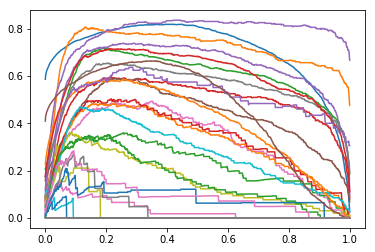

In [100]:
print('Last model after fine-tuning')
T1, ff1 = getOptimalT(model2, valGen)
#T1[T1<0.1] = 0.1

In [101]:
#OriginalT1 = T1.copy()
#T1[T1 < 0.1] = 0.1

In [102]:
from sklearn.metrics import f1_score as offl

def calcF1Score(mdl, valGen, T):
    
    valPred = np.empty((0, 28))
    valLabels = np.empty((0, 28))
    preds = np.empty((0, 28))
    for i in tqdm(range(len(valGen))): 
        im, lbl = valGen[i]
        scores = mdl.predict(im)
        valPred = np.append(valPred, scores, axis=0)
        valLabels = np.append(valLabels, lbl, axis=0)
    p = np.array(valPred>T, dtype=np.int8)
#    scoref1 = K.eval(f1(valLabels, p))
    scoref1 = off1(valLabels, p, average='macro')
#            f1s[j,i] = scoref1
#    preds = lastFullValPred > T
    return scoref1
#    skf1 = offl(lastFullValPred, lastFullValLabels)
#    localf1 = f1(lastFullValPred, lastFullValLabels)
    
    
#    return skf1, localf1

In [103]:
#tf.reset_default_graph()
#K.clear_session()
#valGen = ProteinDataGenerator(pathsVal,labelsVal, BATCH_SIZE, SHAPE)
#bestModelPlateau = load_model('../working/ResNet50A.h5', custom_objects={'f1': f1}) #, 'f1_loss': f1_loss})
T = T1
skf1 = calcF1Score(model2, valGen, T)
print("F1 score of model", skf1, '   using ',T)
T = threshold
skf2 = calcF1Score(model2, valGen, T)
print("F1 score of model", skf2, '   using ',T)
if (skf1 > skf2):
    saveT = T1
    saveF1 = skf1
else:
    saveT = threshold
    saveF1 = skf2

  0%|          | 0/98 [00:00<?, ?it/s]

F1 score of model 0.4566753131808385    using  [0.418 0.132 0.192 0.216 0.255 0.228 0.348 0.204 0.036 0.03  0.066 0.18
 0.257 0.215 0.419 0.002 0.047 0.095 0.086 0.117 0.067 0.258 0.143 0.212
 0.275 0.339 0.092 0.   ]


100%|██████████| 98/98 [01:37<00:00,  1.35it/s]

F1 score of model 0.38902073748822225    using  0.35


In [106]:
T = T1
# Create submit
submit = pd.read_csv('../input/sample_submission.csv')
predicted = []
draw_predict = []
#model.load_weights(modelFile)
for name in tqdm(submit['Id']):
    path = os.path.join('../input/test/', name)
    image = train_generator.load_image(path)
    score_predict = model2.predict(image[np.newaxis])[0]
    draw_predict.append(score_predict)
    label_predict = np.arange(28)[score_predict>=T]
    str_predict_label = ' '.join(str(l) for l in label_predict)
    predicted.append(str_predict_label)

submit['Predicted'] = predicted
np.save('draw_predict_ResNet50.npy', score_predict)
submit.to_csv(submitFile, index=False)

100%|██████████| 11702/11702 [03:30<00:00, 55.67it/s]


In [107]:
from sklearn.metrics import f1_score as offl

def getPredLabels(mdl, generator, T):
    
    pred = np.empty((0, 28))
    labels = np.empty((0, 28))
    for i in tqdm(range(len(generator))): 
        im, lbl = generator[i]
        scores = mdl.predict(im)
        pred = np.append(pred, scores, axis=0)
        labels = np.append(labels, lbl, axis=0)

    p = np.array(pred>T, dtype=np.float)
    return p, labels, pred

In [108]:
T = T1
p,labels,predProbs = getPredLabels(model2, valGen, T)

100%|██████████| 98/98 [01:37<00:00,  1.33it/s]


5.8510516032639925 94.148948396736 10182.0 6215 28 174020


Text(0, 0.5, 'Percentage')

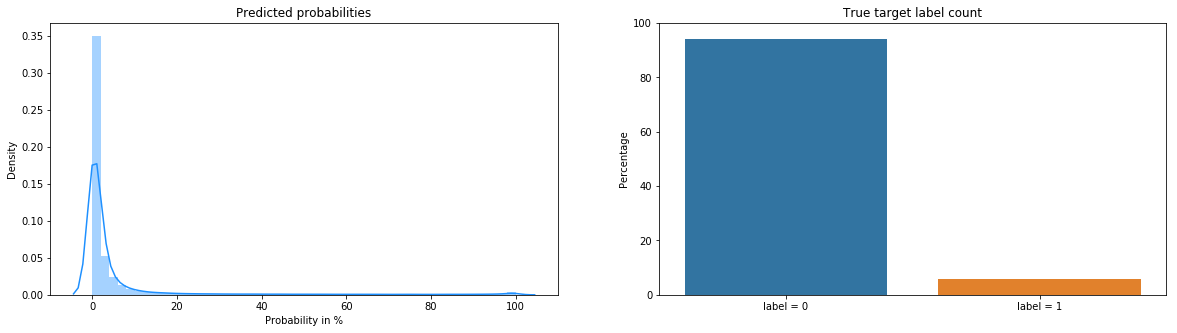

In [109]:

import seaborn as sns
one_hot = labels.sum() / (labels.shape[0]*labels.shape[1]) * 100
zero_hot = ((labels.shape[0]*labels.shape[1] - labels.sum()) / (labels.shape[0]*labels.shape[1])) * 100
print(one_hot, zero_hot, labels.sum(), labels.shape[0], labels.shape[1], labels.shape[0]*labels.shape[1])
fpredProbs = predProbs.reshape(-1)
fig, ax = plt.subplots(1,2, figsize=(20,5))
sns.distplot(fpredProbs * 100, color="DodgerBlue", ax=ax[0])
ax[0].set_xlabel("Probability in %")
ax[0].set_ylabel("Density")
ax[0].set_title("Predicted probabilities")
sns.barplot(x=["label = 0", "label = 1"], y=[zero_hot, one_hot], ax=ax[1])
ax[1].set_ylim([0,100])
ax[1].set_title("True target label count")
ax[1].set_ylabel("Percentage")

In [110]:
import numpy as np
import itertools
import matplotlib.pyplot as plt
eps = np.finfo(float).eps
def ml_confusion_matrix_counts(yt, yp, classes):
    instcount = yt.shape[0]
    n_classes = classes.shape[0]
    mt = np.zeros((n_classes, 4))
    mtx = np.zeros((n_classes, 7))
    for i in range(instcount):
        for c in range(n_classes):
            mt[c,0] += 1 if yt[i,c]==1 and yp[i,c]==1 else 0  #TP
            mt[c,1] += 1 if yt[i,c]==1 and yp[i,c]==0 else 0  #FN
            mt[c,2] += 1 if yt[i,c]==0 and yp[i,c]==0 else 0  #TN
            mt[c,3] += 1 if yt[i,c]==0 and yp[i,c]==1 else 0  #FP
    return mt

In [111]:
import numpy as np
import itertools
import matplotlib.pyplot as plt
eps = np.finfo(float).eps
def ml_confusion_matrix(yt, yp, classes):
    instcount = yt.shape[0]
    n_classes = classes.shape[0]
    mt = np.zeros((n_classes, 4))
    mtx = np.zeros((n_classes, 7))
    for i in range(instcount):
        for c in range(n_classes):
            mt[c,0] += 1 if yt[i,c]==1 and yp[i,c]==1 else 0  #TP
            mt[c,1] += 1 if yt[i,c]==1 and yp[i,c]==0 else 0  #FN
            mt[c,2] += 1 if yt[i,c]==0 and yp[i,c]==0 else 0  #TN
            mt[c,3] += 1 if yt[i,c]==0 and yp[i,c]==1 else 0  #FP
    for c in range(n_classes):
        mtx[c,0] = mt[c,0]/(mt[c,0] + mt[c,3]) if (mt[c,0] + mt[c,3]) > 0 else 0
        mtx[c,1] = mt[c,3]/(mt[c,0] + mt[c,3]) if (mt[c,0] + mt[c,3]) > 0 else 0
        mtx[c,2] = mt[c,1]/(mt[c,1] + mt[c,2]) if (mt[c,1] + mt[c,2]) > 0 else 0
        mtx[c,3] = mt[c,2]/(mt[c,1] + mt[c,2]) if (mt[c,1] + mt[c,2]) > 0 else 0
        mtx[c,4] = mt[c,0]/(mt[c,0] + mt[c,3]) if (mt[c,0] + mt[c,3]) > 0 else 0
        mtx[c,5] = mt[c,0]/(mt[c,0] + mt[c,1]) if (mt[c,0] + mt[c,1]) > 0 else 0
        mtx[c,6] = 2 * (mtx[c,4] * mtx[c,5])/(mtx[c,4] + mtx[c,5]) if (mtx[c,4] + mtx[c,5]) > 0 else 0
    return mtx

In [112]:
clss = np.array(list(label_names.values()))
n_classes = len(clss)

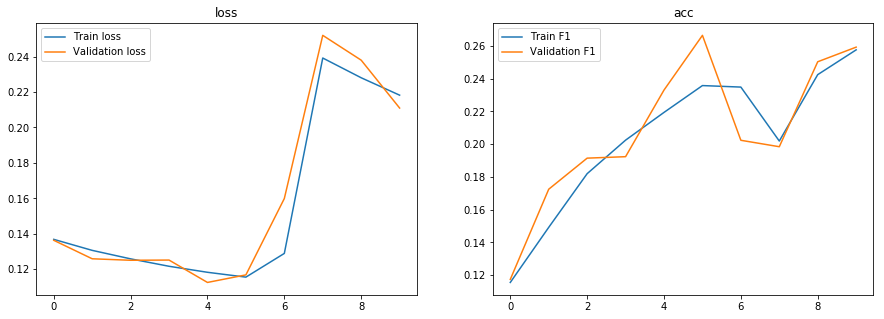

In [113]:
fig, ax = plt.subplots(1, 2, figsize=(15,5))
ax[0].set_title('loss')
ax[0].plot(hist2.epoch, hist2.history["loss"], label="Train loss")
ax[0].plot(hist2.epoch, hist2.history["val_loss"], label="Validation loss")
ax[1].set_title('acc')
ax[1].plot(hist2.epoch, hist2.history["f1"], label="Train F1")
ax[1].plot(hist2.epoch, hist2.history["val_f1"], label="Validation F1")
ax[0].legend()
ax[1].legend()

In [114]:
mtx = ml_confusion_matrix(labels, p, clss)
mt = ml_confusion_matrix_counts(labels, p, clss)

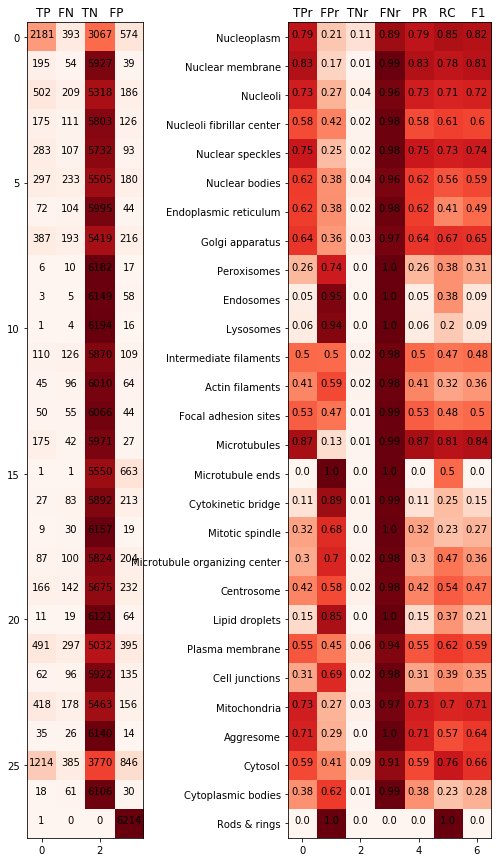

In [115]:
fig, ax = plt.subplots(1, 2, figsize=(10,15),facecolor='w', edgecolor='k')
tick_marks = np.arange(n_classes)
plt.yticks(tick_marks, clss)

ax[1].set_title("TPr  FPr  TNr   FNr   PR   RC    F1")
ax[1].imshow(mtx, interpolation='nearest',cmap='Reds')
ax[1].set_title("TPr  FPr  TNr   FNr   PR   RC    F1")
for i, j in itertools.product(range(n_classes), range(7)):
    ax[1].text(j, i, round(mtx[i][j],2), horizontalalignment="center")

ax[0].imshow(mt, interpolation='nearest',cmap='Reds')
ax[0].set_title("TP  FN  TN   FP   ")
for i, j in itertools.product(range(n_classes), range(4)):
    ax[0].text(j, i, int(mt[i][j]), horizontalalignment="center")

In [116]:
from scipy.misc import imread
def load_image(basepath, image_id):
    images = np.zeros(shape=(512,512,4))
    images[:,:,0] = imread(image_id + "_green" + ".png")
    images[:,:,1] = imread(image_id + "_red" + ".png")
    images[:,:,2] = imread(image_id + "_blue" + ".png")
    images[:,:,3] = imread(image_id + "_yellow" + ".png")

    return images



def make_image_row(image, subax, title):
    subax[0].imshow(image[:,:,0], cmap="Greens")
    subax[0].set_title(title)
    subax[1].imshow(image[:,:,1], cmap="Reds")
    subax[1].set_title("stained microtubules")
    subax[2].imshow(image[:,:,2], cmap="Blues")
    subax[2].set_title("stained nucleus")
    if (image.shape[2] == 4):
        subax[3].imshow(image[:,:,3], cmap="Oranges")
        subax[3].set_title("stained endoplasmatic reticulum")
    return subax
def make_title(lab):
    file_targets = [label_names[idx] for idx in range(28) if int(lab[idx]) ==1]
#    file_targets = np.where(lab[file_id] == 1)[0]
    title = " - "
    for n in file_targets:
        title += n + " - "
    return title

In [117]:
class TargetGroupIterator:
    
    def __init__(self, target_names, batch_size, basepath):
        self.target_names = target_names
        self.target_list = [reverse_train_labels[key] for key in target_names]
        self.batch_shape = (batch_size, 512, 512,4)
        self.basepath = basepath
        self.images_identifier = []
    
    def find_matching_data_entries(self):
        y = np.zeros(28)
        cnt = 0
        for key in self.target_list:
            y[int(key)] = 1
            cnt += 1
        for i in range(len(labelsTrain)):
            if ((int(np.dot(labelsTrain[i], y)) == cnt)):
                self.images_identifier.append(i)
        
#        self.images_identifier = train_labels[train_labels.check_col==1].Id.values
#        train_labels.drop("check_col", axis=1, inplace=True)
    
    def check_subset(self, targets):
        return np.where(set(targets).issubset(set(self.target_list)), 1, 0)
 #        return np.where(set(targets).issubset(set(self.target_list)), 1, 0)
    
    def get_loader(self):
        filenames = []
        idx = 0
        images = np.zeros(self.batch_shape)
        for image_id in self.images_identifier:
            images[idx,:,:,:] = load_image(self.basepath, pathsTrain[image_id])
            filenames.append(image_id)
            idx += 1
            if idx == self.batch_shape[0]:
                yield filenames, images
                filenames = []
                images = np.zeros(self.batch_shape)
                idx = 0
        if idx > 0:
            yield filenames, images

In [118]:
def getFailedPredImagesLabels(mdl, generator,numFailures, T):
    images = []
    labels = []
    ps = []
    cnt = 0
    j = 0
    while (cnt < numFailures):
        im, lbl = generator[j]
        scores = mdl.predict(im)
        p = np.array(scores>T, dtype=np.float)
        i = 0
        while i < len(lbl) and cnt < numFailures:
            if (np.dot(p[i], lbl[i]) == 0):
                images.append(im[i])
                ps.append(p[i])
                labels.append(lbl[i])
                cnt += 1
            i += 1
        j += 1
    return np.array(images),np.array(ps), np.array(labels)

def getNames(y):
    names = []
    for id in range(y.shape[0]):
        idNames = [label_names[idx] for idx in range(28) if y[id][idx] ==1]
        for aName in idNames:
            if aName not in names:
                names.append(aName)
    return list(names)

In [119]:
numFailures = 3
T = threshold
images, ps, trueLabels = getFailedPredImagesLabels(model2, valGen,numFailures, T)

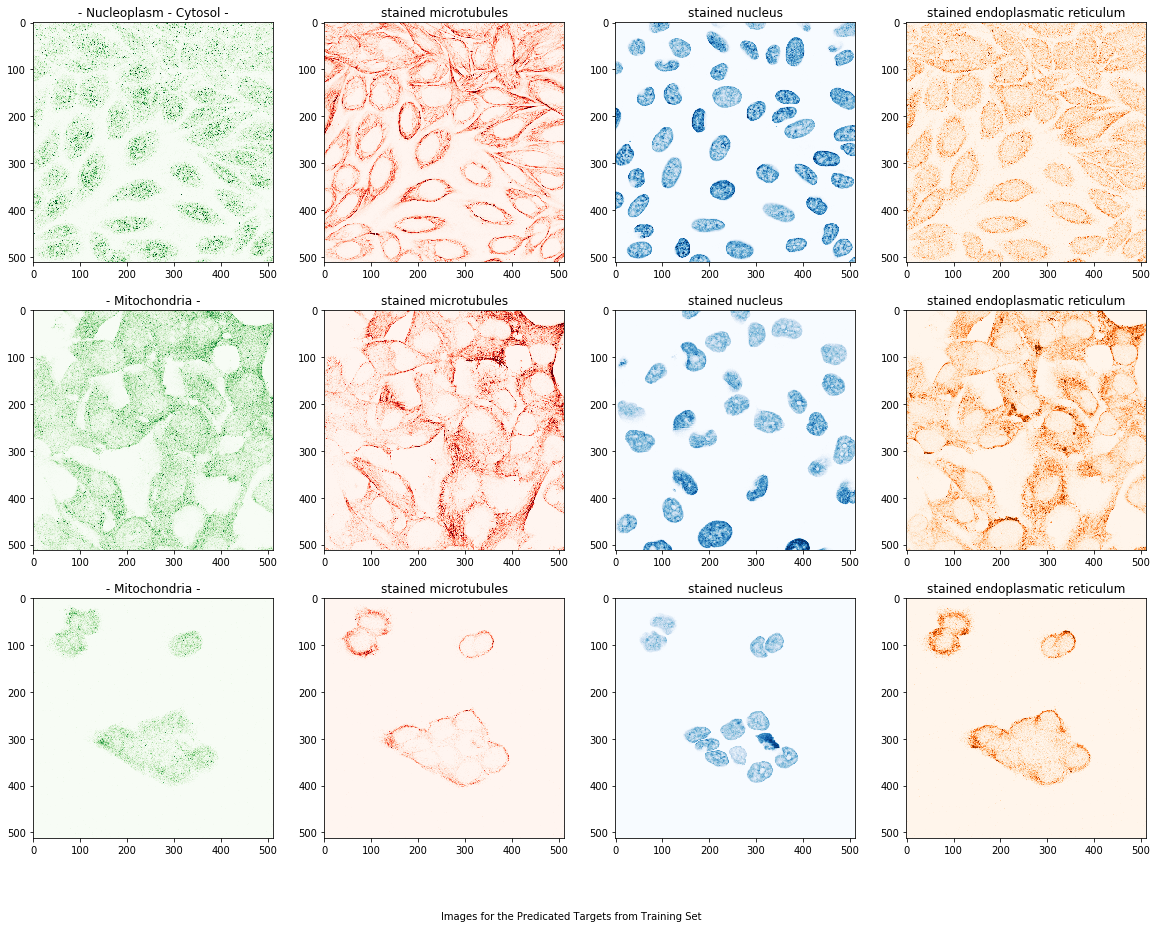

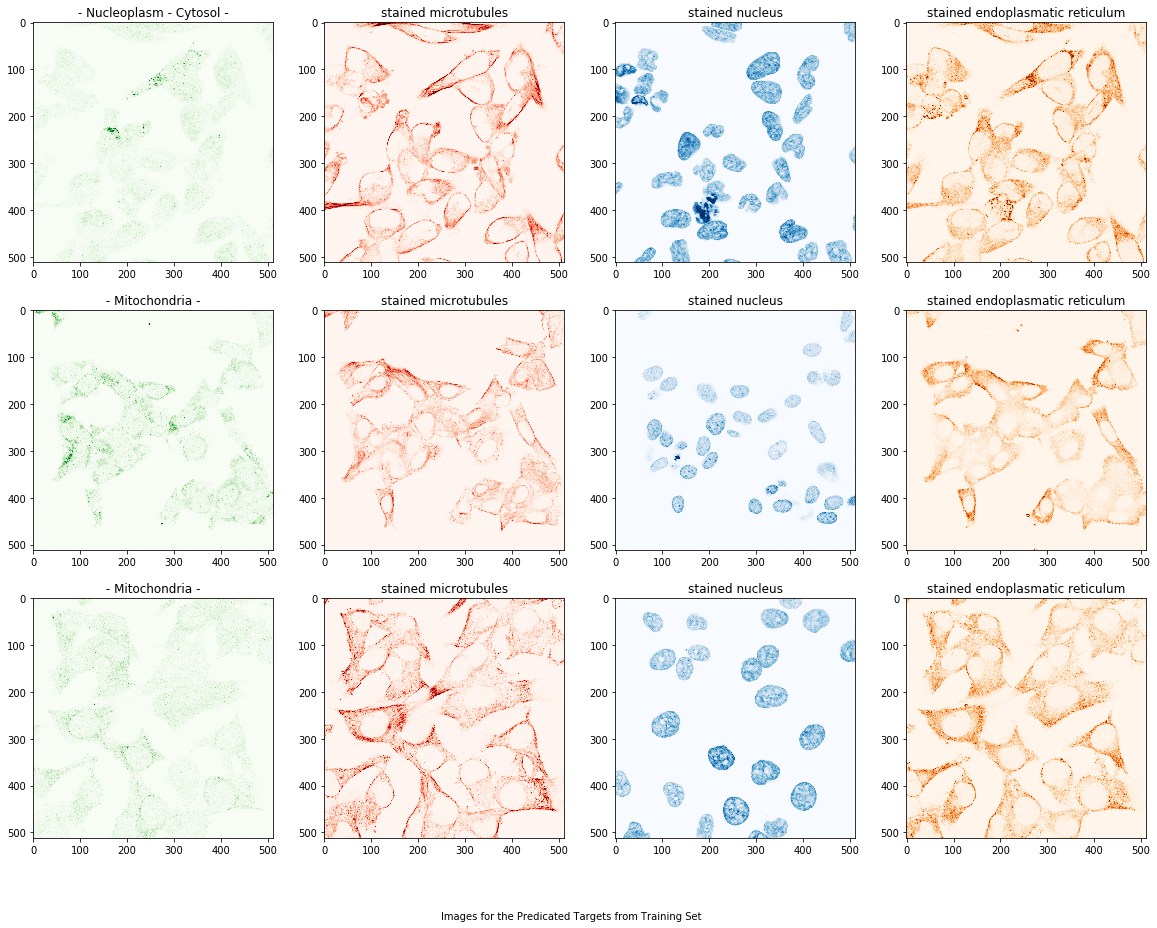

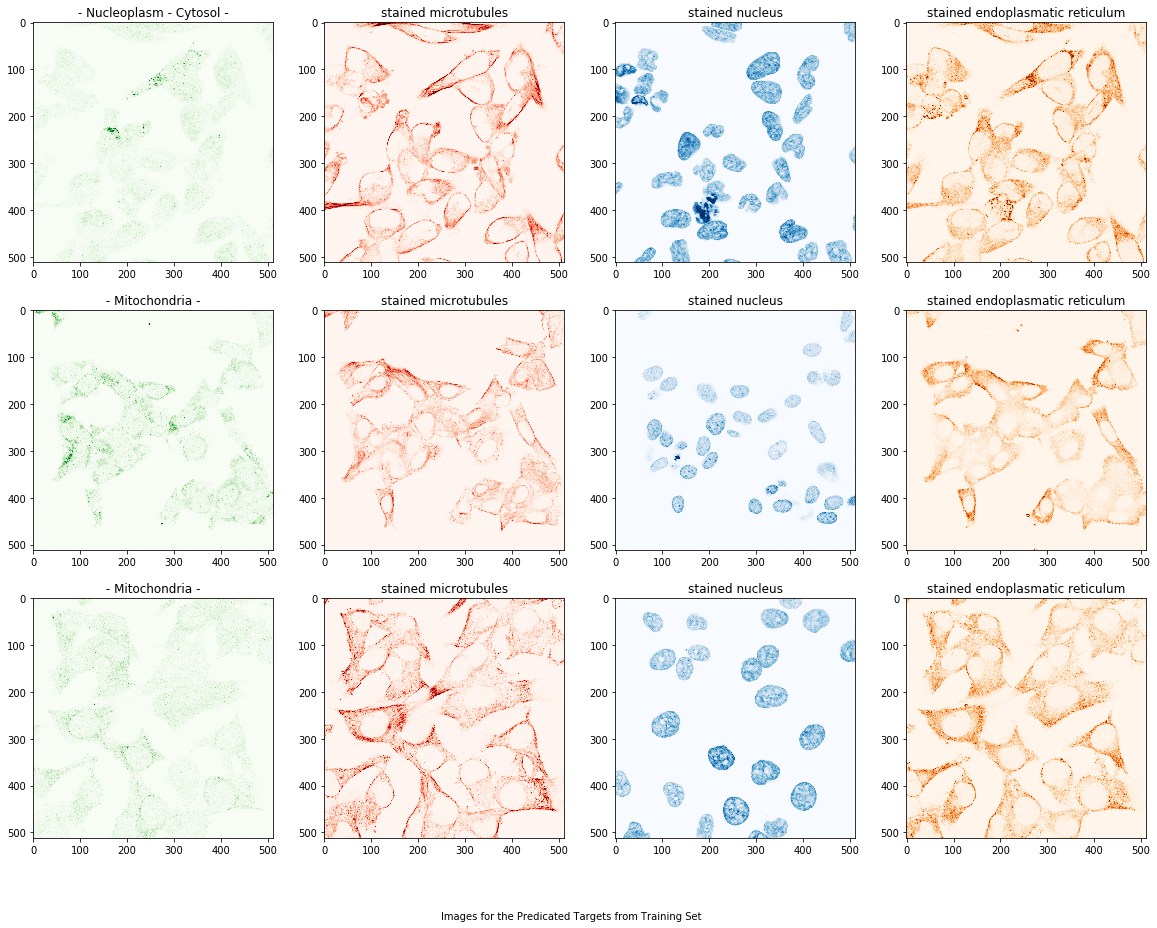

In [122]:
numImages = 3
numChannels =4
for i in range(numFailures):
    proteinNames = [label_names[idx] for idx in range(28) if ps[i][idx] ==1]
    imageloader = TargetGroupIterator(proteinNames,numImages , '../input/train')
    imageloader.find_matching_data_entries()
    iterator = imageloader.get_loader()
    file_ids, images = next(iterator)
    fig, ax = plt.subplots(numImages,numChannels,figsize=(20,5*numImages))
    txt = "Images for the Predicated Targets from Training Set"
    fig.text(.5, .05, txt, ha='center')
    if ax.shape == (4,):
        ax = ax.reshape(1,-1)
    for n in range(len(file_ids)):
        make_image_row(images[n], ax[n], make_title(ps[n]))

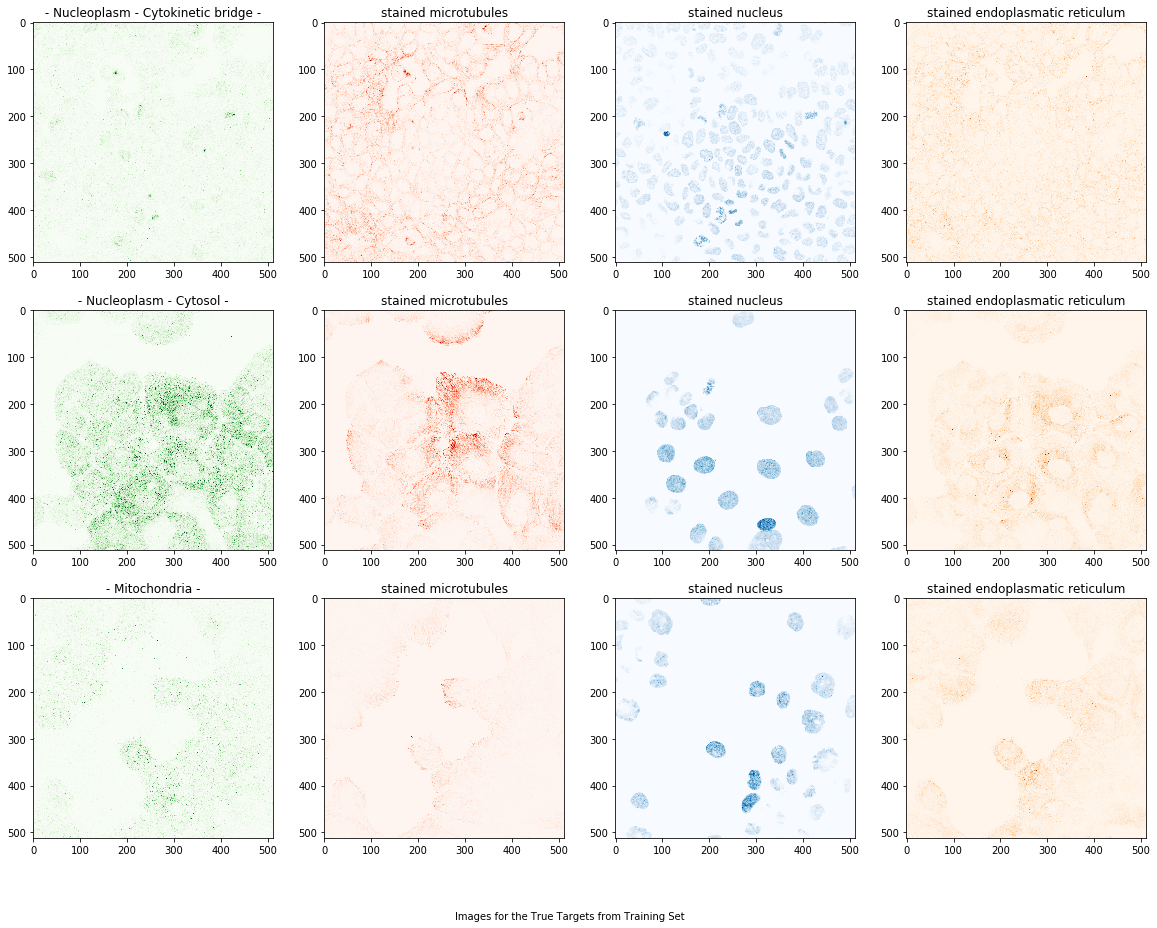

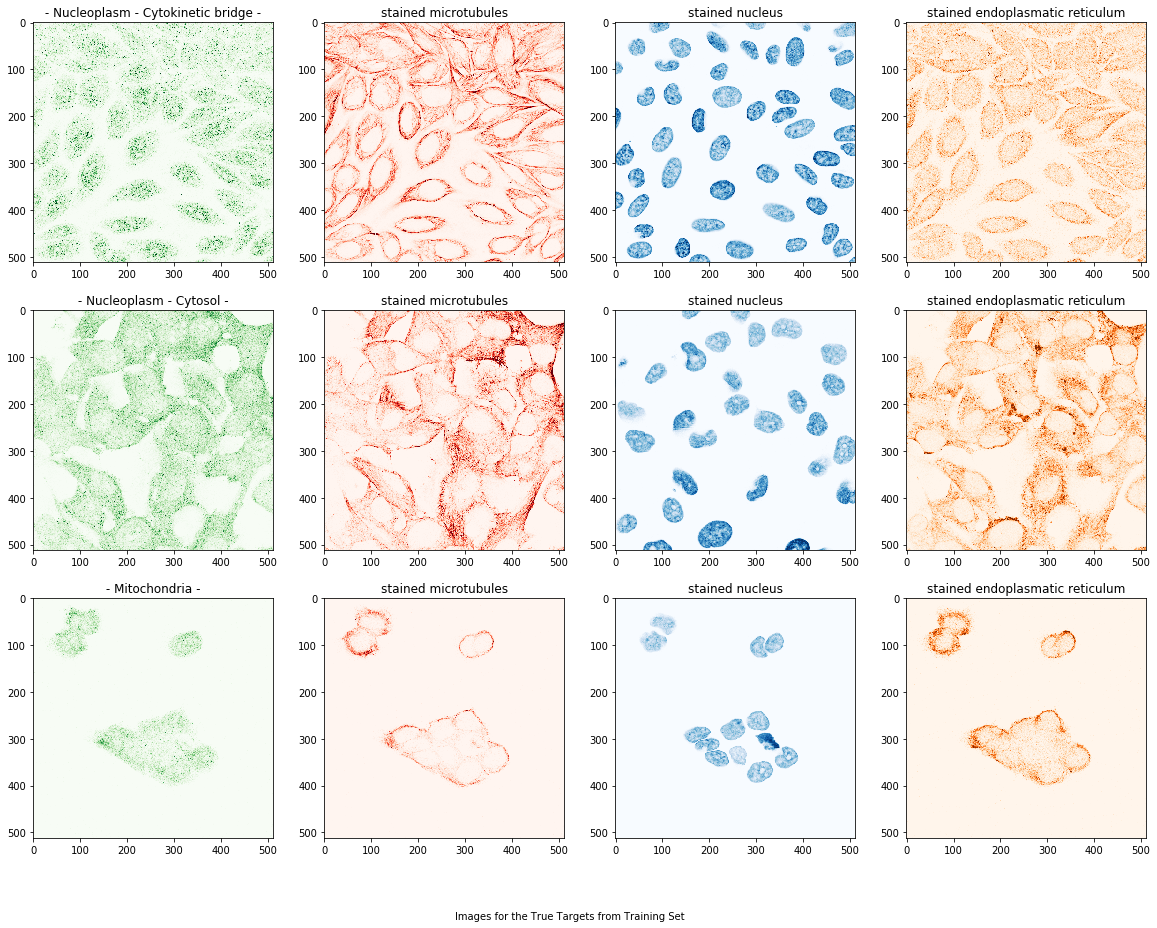

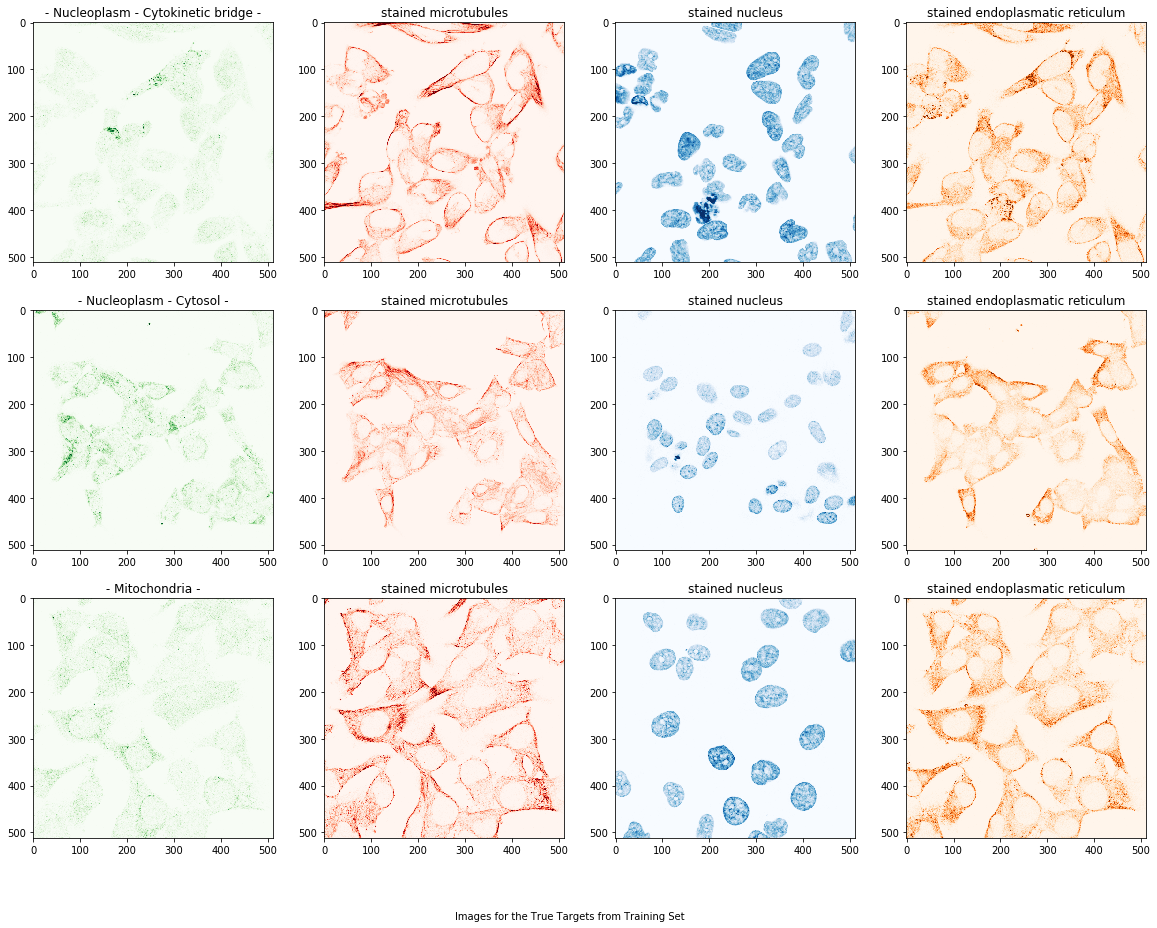

In [123]:
numImages = 3
numChannels =4
for i in range(numFailures):
    proteinNames = [label_names[idx] for idx in range(28) if labels[i][idx] ==1]
    imageloader = TargetGroupIterator(proteinNames,numImages , '../input/train')
    imageloader.find_matching_data_entries()
    iterator = imageloader.get_loader()
    file_ids, images = next(iterator)
    fig, ax = plt.subplots(numImages,numChannels,figsize=(20,5*numImages))
    txt = "Images for the True Targets from Training Set "
    fig.text(.5, .05, txt, ha='center')
    if ax.shape == (4,):
        ax = ax.reshape(1,-1)
    for n in range(len(file_ids)):
        make_image_row(images[n], ax[n], make_title(labels[n]))

In [124]:
# Better formatting needed hours, minutes, etc
done = time.time()
elapsed = done - start
print(int(elapsed/60), " minutes")

172  minutes


In [126]:
print("Summary Statistics")
print("F1 ", saveF1, "T ", saveT, "lr ",lr, "STAGE 1 epochs: ", epochs, "STAGE 2 epochs:", epochs, "BATCH_SIZE ", BATCH_SIZE, "SHAPE STAGE 1 ", CUST_SHAPE, "SHAPE STAGE 2", SHAPE)


Summary Statistics
F1  0.4566753131808385 T  [0.418 0.132 0.192 0.216 0.255 0.228 0.348 0.204 0.036 0.03  0.066 0.18
 0.257 0.215 0.419 0.002 0.047 0.095 0.086 0.117 0.067 0.258 0.143 0.212
 0.275 0.339 0.092 0.   ] lr  0.001 STAGE 1 epochs:  10 STAGE 2 epochs: 10 BATCH_SIZE  64 SHAPE STAGE 1  (128, 128, 4) SHAPE STAGE 2 (224, 224, 4)
